# Prédiction de séries temporelle avec Python

Dans ce notebook, nous allons essayer de préduire le cours du bitcoin minute par minute en utilisant un réseau de neurone. Le réseau choisi est un LSTM.

## Import Général

In [41]:
import torch
import torch.nn as nn
from datetime import date
from datetime import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from skorch import NeuralNet
import pandas as pd
from skorch.callbacks import LRScheduler
from sklearn.model_selection import GridSearchCV
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import joblib

# pour installer les packages 
# conda install pytorch==1.9.0 cudatoolkit=11.3 -c pytorch
# pip install torch==1.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# conda install -c anaconda scikit-learn
# pip install -U scikit-learn

# conda install -c conda-forge skorch
# pip install -U skorch

# Les données

## Etape 0 : la collecte des données

Comme nous partons de rien, nous devons d'abord collecter les données. Pour cela, il existe plusieurs solutions. Avant de pouvoir collecter les données, il faut savoir où les trouver.

En faisant une recherche sur google, on trouve beaucoup de site web proposant le cours du bitcoin. Pour ne citer que les plus connues : https://fr.finance.yahoo.com/ ou https://www.google.com/finance/?hl=fr

Une fois qu'on sait où trouver les données, il faut l'extraire. Pour cela, nous pouvons utiliser le web scrapping. Il s'agit de la première approche que j'ai choisi d'utiliser. Elle comporte son lot d'avantage et d'inconvénient. Vous retrouverez les tableaux récapitulatifs ci-dessous. 

### Selenium 
    
&nbsp; &nbsp; &nbsp; Selenium est une librairie développée sur plusieurs langage et disponible sur python. Cette librairie permet de réaliser toutes les interactions faisables sur un navigateur web. Une fois qu'on a bien configuré Selenium et qu'on a pris ses marques avec il est relativement facile à utiliser. On peut facilement adapter son script à un autre site web. Il suffit juste de connaître les balises html adéquat. Voici la documentation de la librairie : https://selenium-python.readthedocs.io/. 
    
&nbsp; &nbsp; &nbsp; Ainsi, le script mis en place actualisait toutes les minutes la page web et récupérer la valeur du cours affichée sur le site. Puis on enregistrait ces valeurs dans un fichier csv.

&nbsp; &nbsp; &nbsp; Le problème de cette solution est qu'elle nécessite une bonne bande passante. Car à chaque minute, nous actualisons la page du site. Si cette page est volumineuse et si votre réseau internet a de la latence alors vous n'aurez pas le cours minutes par minutes. C'est ce qu'il s'est passé lors de la mise en place de cette solution. Il me manquait des valeurs pour certaines minutes. Ce qui peut fortement impacter notre modèle, car il nous faut des données continues dans le temps. Une solution pour remédier à ce problème aurait été de remplacer les valeurs manquantes par des valeurs fictives qu'on doit créer. On peut faire se procéder avec des interpolations ou en faisant la moyenne des valeurs qui précédent et suivent notre valeur manquante. C'est pourquoi, l'autre solution a été privilégiée.

### API REST

&nbsp; &nbsp; &nbsp; Une autre solution possible pour récupérer les données consiste à utiliser les requêtes API REST envoyées lors de la navigation sur le site. Cette méthode a l'avantage d'être plus fiable, car nous ne rechangeons pas toute la page, mais nous demandons seulement les données qui nous intéressent. Ainsi une fois que nous avons identifié la bonne requête à envoyer (ceci peut se faire via l'onglet network de la touche F12), nous pouvons facilement enregistrer les données via un script et automatiser ce script sur un serveur via CRON par exemple. C'est ce qui est mis en place actuellement.

&nbsp; &nbsp; &nbsp; Ainsi, avec cette solution, la requête API nous permet de récupérer la valeur du bitcoin minute par minute et ceux sur les 5 derniers jours. Donc, nous lançons le script tous les 5 jours puis nous fusionnons les données avec celle déjà enregistrées. L'avantage, c'est que nos données sont continues, car c'est le site web qui nous les envoie. 

&nbsp; &nbsp; &nbsp; Le problème avec cette solution, est qu'il est assez difficile d'identifier la bonne requête API sans aucune documentation du site. Il faut alors décortiquer les requêtes du site et trouver les bons paramètres, etc. De plus, cette méthode à l'inconvénient de ne pas s'adapter à d'autres sites. Si nous voulons récolter des données sur un autre site alors il faut tout réanalyser les requêtes de ce dernier. 

<table style="border: 1px solid #333;table-layout:fixed;">
    <thead style="background-color: #333;color: #fff;">
        <tr>
            <th colspan="2" style="text-align:center;">Selenium</th>
            <th colspan="2" style="text-align:center;">API REST</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="width: 25%;"> ➕ Avantages</td>
            <td style="width: 25%;"> ➖ Inconvénients </td>
            <td style="width: 25%;"> ➕ Avantages</td>
            <td style="width: 25%;"> ➖ Inconvénients </td>
        </tr>
        <tr>
            <td style="width: 25%;" >
              <ol>
                <li>Facile à déployer sur plusieurs sites </li>
                <li>Faire plusieurs actions de manières simple </li>
              </ol>
            </td>
            <td style="width: 25%;"> 
              <ol>
                <li> Configuration peut être un peu laborieuse avec les pilotes à installer </li>
                <li> Nécéssite une bonne bande passante pour recharger une page web régulièrement </li>
              </ol> 
            </td>
            <td style="width: 25%;"> 
              <ol>
                <li> Très fiable, permet de récupérer des données sans trop de discontinuité</li>
                <li> facile à automatiser avec une tâche CRON </li>
              </ol>
            </td>
            <td style="width: 25%;"> 
              <ol>
                <li> Ne fonctionne plus si votre site change ses requêtes</li>
                <li> Analyser le traffic réseau lors de la navigation sur le site pour trouver la bonne REST </li>
              </ol>
            </td>
        </tr>
    </tbody>
</table>

Les données sont les valeurs du bitcoin avec différentes informations relatives au cours. Comme la valeur à la clôture ou à la fermeture par exemple. Nous devons traiter les données pour pouvoir les exploiter.

Pour cela, il existe une bibliothèque sur python : *pandas*. Pandas nous permet de générer des données et de réaliser du traitement dessus assez facilement.

Vous retrouverez la documentation de Pandas sur le lien suivant : https://pandas.pydata.org/docs/.

## Etape 1 : Charger les données

Nous chargeons les données stockées dans un fichier csv dans un objet DataFrame de *Pandas*. On précise que nos données sont séparées par un ';' et que la colonne correspondant à l'index est la colonne 'time'. 

## Etape 2 : nettoyer les données

&nbsp; &nbsp; &nbsp; Cette étape est très importante. Elle permet de traiter les données manquantes ou les données erronées. Cela peut être des données avec des informations manquantes par exemple. Dans notre cas, nous n'avons aucune donnée manquante. Toutes les données que nous avons sont continues dans le temps.

## Etape 3 : traiter les données

&nbsp; &nbsp; &nbsp; Maintenant, nous devons traiter les données. C'est-à-dire que nous avons des données qui sont différentes entre elles. Par exemple, nous pouvons imaginer que nous avons des données avec comme première caractéristique un poids en Tonne et nous pouvons imaginer une autre caractéristique avec un poids en g. L'écart d'échelle est très grand et la comparaison des deux caractéristiques n'est pas possible. L'étude des corrélations devient alors plus compliquée à réaliser avec des plages de variation très grande.

&nbsp; &nbsp; &nbsp; Ainsi, nous normalisons les données pour pouvoirs mieux les utiliser. Normaliser les données veut dire que la plage de variation de celle-ci se situe entre 0 et 1. L'autre avantage de normaliser les données, c'est que cela demande moins de ressource aux algorithmes pour faire les calcules.

&nbsp; &nbsp; &nbsp; Ici, nous utilisons la normalisation standard qui consiste à soustraire la moyenne et à la diviser par l’écart-type soit X l'ensemble de nos données, on normalise X par $|X| = \frac{X - \mu}{\sigma}$. Ou μ représente la moyenne et σ représente l'écart-type. Dans ce cas, chaque valeur refléterait la distance par rapport à la moyenne en unités d’écart-type. Si nous supposons que toutes les variables proviennent d’une distribution normale, la normalisation les rapprocherait toutes de la distribution normale standard. La distribution résultante a une moyenne de 0 et un écart-type de 1.

&nbsp; &nbsp; &nbsp; D'autres normes existent comme la normalisation de moyenne (normalisation min max), dont la distribution résultante sera entre -1 et 1 avec une moyenne = 0. Ou les normes $L_p$ et encore bien d'autres, cette notion est découle de l'algèbre cf https://fr.wikipedia.org/wiki/Norme_(math%C3%A9matiques)



In [42]:
# Fonction qui traite le DataFrame, il est subit la normalisation standard
# Input : 
#     - un DataFrame qu'on souhaite normaliser
# Output : 
#     - le DataFrame normaliser
#     - la moyenne (ou les moyennes) du DataFrame
#     - l'écart-type (ou les écarts-types) du DataFrame
def prepross_data(data):
    #enlève les valeurs vides
    data.dropna(axis=0,inplace=True)
    mean = data.mean()
    std = data.std()
    data =(data-mean)/std
    return mean,std,data

Maintenant que nous avons normé nos données, il faut formaliser une structure de donnée pour pouvoir les utiliser avec nos algorithmes. Il faut pour cela choisir un nombre de caractéristiques qu'on peut extraire de nos données. Cela peut-être les valeurs brutes ou on peut réaliser préalablement un traitement sur les données tel qu'une combinaison linéaire des données brutes.

Ainsi construisons un vecteur $\overrightarrow{x}$ qui sera passé à notre modèle pour l'apprentissage mais aussi pour la prédiction. 

Ce vecteur est composé de caractéristiques (features). Il nous reste à définir ce nombre de caractéristiques notons le $N_{features}$ . 

Donc $\overrightarrow{x} \in \mathbb{R}^{N_{features}} \;$ .

Ici les features correspondent à la valeur du bitcoin à la clôture à chaque minute. Nous choisissons donc un vecteur qui contient les valeurs du bitcoin à la clôture sur $N_{features}$ minutes consécutives.

Une autre possibilité est de passer les valeurs de la clôture, l'ouverture et d'autre valeur qu'on connait ou qu'on a calculé chaque minutes.

Au lieu de passer un seul vecteur à notre modèle pour qu'il puisse apprendre. Il existe un mode appelé le mode batch, qui permet de passer plusieurs vecteurs à notre modèle ce qui lui permet d'apprendre sur plusieurs vecteurs. Cela permet d'éviter certains biais introduits par un vecteur car notre modèle moyenne l'apprentissage sur l'ensemble des vecteurs.

Maintenant, il faut labelliser les données pour pouvoir indiquer à notre modèle quelle est valeur de terrain par rapport à celle qui a prédit. Concrètement, imaginons que nous ayons les valeurs du bitcoin sur 6 minutes, les 5 premières minutes correspondent aux caractéristiques (features) et forment un « vecteur de features » et la $6^{ème}$ minute correspond au label associé à ce vecteur. Ainsi, il pourra calculer son erreur entre la valeur prédite et la vraie valeur.

In [43]:
#Constante

numFeature = 5


In [44]:
# Fonction qui créer un vecteur x à partir d'un index et d'un DataFrame
# Input : 
#     - l'index sur la première valeur du vecteur
#     - un DataFrame contenant toutes les valeurs
# Output : un vecteur x, contenant les valeur de cloture du bitcoin des N prochaines minutes à partir de l'index. 
def create_input(index,pdData):
    return pdData["cloture"].iloc[index:index+numFeature+1].values.tolist()


In [45]:
# Méthode qui permet de convertir un index de notre DataFrame en un dateTime
def convert_index_to_datetime(index):
    #la première date de notre base de donnée
    date = datetime.datetime.strptime(str(index)[:6],"%y%m%d")
    hour = int(str(index)[7:-1])//60
    minute = int(str(index)[7:-1])%60
    index_datetime = date + datetime.timedelta(hours=hour) + datetime.timedelta(minutes=minute)
    return index_datetime


In [46]:
#Methode qui créer un batch contenant l'ensemble des vecteurs et des labels associées utilisé lors de l'apprentissage.
# input: DataFrame contenant les données
# output: le batch contenant tous les vectueurs du DataFrame avec les labels
def create_batchs_and_labels(data):

    iterator = 0
    labels =[]
    batch =  []
    #On boucle sur la base de donnée :
    while (iterator <= data.shape[0]-numFeature-1):   

        dataExtracted = create_input(iterator,data)
        if (len(dataExtracted) == numFeature+1):
            sequence = []
            for x in dataExtracted[:-1]:
                sequence.append([x])
            batch.append(sequence)
            labels.append([dataExtracted[-1]])
        iterator+=1
    return torch.FloatTensor(batch),torch.FloatTensor(labels)

Pour avoir une structure plus facile d'utilisation, on va utiliser la bibliothèque pytorch. On va utiliser l'object Dataset. Ce qui va nous permettre de mieux gérer nos données pour l'apprentissage. Voici la documentation : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In [47]:
from torch.utils.data import Dataset

class Dataset(torch.utils.data.Dataset):    
    def __init__(self, data_file):
        pf = pd.read_csv(str(data_file),sep=';',index_col='time')
        self.mean,self.std,self.prepross_pf = prepross_data(pf)
        self.batch,self.labels = create_batchs_and_labels(self.prepross_pf)
        
    def __len__(self):
        return self.batch.shape[0]

    def __getitem__(self, idx):
        return self.batch[idx],self.labels[idx]


Ainsi on créer notre Dataset à partir de notre csv. 

In [48]:
# training = Dataset("./bitcoin.csv")
training = Dataset("../data/train/bitcoin.csv")

Puis on créer un Dataloader qui va charger les données pour pouvoir les utiliser et faire des calculs sur celles-ci. Voir la documentation pour plus d'information https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders.

Ici, on demande de faire une permutation sur nos vecteurs pour que l'apprentissage soit fait sur des vecteurs qui ne sont pas liés les uns aux autres par leur temporalité. Ici, le but de notre modèle est d'avoir en entrée un vecteur contenant les valeurs de clôture des $N_{feature}$ dernières minutes et le modèle doit prédire la valeur de la $N_{feature} + 1$ minute

In [49]:
train_dataloader = DataLoader(training, batch_size=100, shuffle=True)

Voici du code pour afficher la tailler des différents batchs qu'on a ainsi chargé pour l'apprentissage

Documentation pytorch du LSTM : https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM

Ici pour notre modèle nous choisissons une taille de 150 neurones pour la couche caché. Avec une seul couche recurrente (une cellule LSTM). Input_size correspond au nombre de feature qui seront passé dans le vecteur x. Ici nous avons qu'une seul feature à savoir la valeur à la clôture. Ne pas confondre input_size avec sequence length. Le premier correspond au nombre de features (caractéristiques) tandis que le second correspond à la taille du vecteur x qui est passé en entrée. 


In [50]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1,num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size,hidden_layer_size,num_layers,batch_first = True)
        # linear layer pour préduire 
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_batch):
        self.hidden_cell = (torch.zeros(self.num_layers,input_batch.size(0),self.hidden_layer_size,device=input_batch.device),
                            torch.zeros(self.num_layers,input_batch.size(0),self.hidden_layer_size,device=input_batch.device))
        lstm_out, self.hidden_cell = self.lstm(input_batch, self.hidden_cell)
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions

On définit maintenant le modèle skorch pour pouvoir faire notre entrainement. 

On réalise un gridSearch pour déterminer le meilleur nombre de neurones. On réalise les calcules sur la carte graphique. 

Voici la documentation de Skorch pour plus d'information : https://skorch.readthedocs.io/en/stable/index.html

In [63]:
net_regr = NeuralNet(
    LSTM,
    optimizer=torch.optim.Adam,
    max_epochs=1000,
    lr=0.001,
    callbacks=[
        LRScheduler(policy='StepLR', step_size=100, gamma=0.1)
    ],
    batch_size=10000,
    iterator_train__shuffle=True,
    criterion=nn.MSELoss,
    device='cuda' 
)


#### Apprentissage

##### Grid search 
 pour déterminer les paramètres
 

In [62]:
torch.cuda.empty_cache()
#paramètre qu'on va déterminer avec le GridSearch
param_grid = {'module__num_layers':[1,5,10,15]}

grid = GridSearchCV(net_regr,param_grid,cv=3,error_score='raise',scoring='neg_mean_squared_error')
   
#on réalise l'entrainement
train_features, train_labels in train_dataloader
grid.fit(train_features,train_labels)

# Sauvegarde du modèle 
saveModel = datetime.today().strftime('%Y%m%d_%H_%M')
# cf doc for more information https://skorch.readthedocs.io/en/stable/user/save_load.html
grid.best_estimator_.save_params(f_params='../resultat/save_models/'+saveModel+'.pkl')

# loading need to initialize net
# net_regr.initialize()  # This is important!
# net_regr.load_params(f_params='some-file.pkl')

# on affiche le meilleur modèle et ses paramètres
print("paramètre à garder pour définir le modèle lors du chargement",grid.best_params_)
print("modèle",grid.best_estimator_)


  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        0.8487        1.0432  0.0010  0.0048
      2        0.8120        0.9948  0.0010  0.0053
      3        0.7754        0.9460  0.0010  0.0050
      4        0.7387        0.8961  0.0010  0.0176
      5        0.7012        0.8447  0.0010  0.0115
      6        0.6626        0.7910  0.0010  0.0112
      7        0.6224        0.7344  0.0010  0.0110
      8        0.5802        0.6745  0.0010  0.0124
      9        0.5356        0.6108  0.0010  0.0097
     10        0.4882        0.5429  0.0010  0.0050
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        0.7536        0.6863  0.0010  0.0107
      2        0.7230        0.6599  0.0010  0.0096
      3        0.6928        0.6333  0.0010  0.0049
      4        0.6626        0.6063  0.0010  0.0104
      5        0.6321        0.5784  0.0010  0.0117
      6     

      2        1.0125        0.7544  0.0010  0.0187
      3        1.0113        0.7497  0.0010  0.0178
      4        1.0111        0.7477  0.0010  0.0181
      5        1.0115        0.7477  0.0010  0.0180
      6        1.0115        0.7488  0.0010  0.0206
      7        1.0112        0.7506  0.0010  0.0299
      8        1.0110        0.7524  0.0010  0.0200
      9        1.0111        0.7537  0.0010  0.0219
     10        1.0112        0.7541  0.0010  0.0210
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        0.9154        0.7785  0.0010  0.0046
      2        0.8831        0.7518  0.0010  0.0042
      3        0.8516        0.7252  0.0010  0.0044
      4        0.8203        0.6982  0.0010  0.0042
      5        0.7886        0.6704  0.0010  0.0047
      6        0.7560        0.6413  0.0010  0.0037
      7        0.7219        0.6105  0.0010  0.0053
      8        0.6859        0.5776  0.0010  0.0039
      9     

##### Apprentissage 
On apprend avec les bon paramètres déterminés

In [64]:
net_regr.fit(training)

# Sauvegarde du modèle 
saveModel = datetime.today().strftime('%Y%m%d_%H_%M')
# cf doc for more information https://skorch.readthedocs.io/en/stable/user/save_load.html
net_regr.save_params(f_params='../resultat/save_models/'+saveModel+'.pkl')

# loading need to initialize net
# net_regr.initialize()  # This is important!
# net_regr.load_params(f_params='some-file.pkl')


  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        1.0071        0.4117  0.0010  0.6566
      2        0.7773        0.2898  0.0010  0.5107
      3        0.4651        0.1107  0.0010  0.6762
      4        0.1004        0.0146  0.0010  0.4485
      5        0.0801        0.0825  0.0010  0.4443
      6        0.0408        0.0042  0.0010  0.4451
      7        0.0182        0.0128  0.0010  0.4595
      8        0.0302        0.0053  0.0010  0.4655
      9        0.0081        0.0060  0.0010  0.4788
     10        0.0074        0.0116  0.0010  0.4805
     11        0.0063        0.0029  0.0010  0.6193
     12        0.0029        0.0016  0.0010  0.4640
     13        0.0042        0.0018  0.0010  0.4692
     14        0.0023        0.0037  0.0010  0.4756
     15        0.0027        0.0034  0.0010  0.4980
     16        0.0021        0.0019  0.0010  0.4808
     17        0.0021        0.0017  0.0010  0.4784
     18     

# Métrique de performance

Les métriques de performance permettent de mesurer l'éfficacité de notre modèle. En effet, les courbes ce suffisent pas, un modèle peut avoir des résultats très bon selon une métrique mais très mauvais selon une autre. Il existe plusieurs métrique en fonction du problème considèré. Ici j'ai choisi de vous présenter les métrique les plus utilisées dans le domaine de la régression. 

Pour l'ensemble des métriques j'utilise la notation suivante :
- $y_i$ est la $i^{ème}$ valeur attendue dans l'ensemble de données 
- $\hat{y_i}$ est la $i^{ème}$ valeur prédite par notre modèle
- $N$ correspond au nombre total de valeur

### Mean squared error

Mean squared error ou MSE (Le carré Moyen des erreurs) est une mesure d'erreur populaire pour les problèmes de régression.

Il s'agit également d'une fonction de perte importante pour les algorithmes ajustés ou optimisés à l'aide du cadrage des moindres carrés d'un problème de régression. L'expression "moindres carrés" fait référence à la minimisation de l'erreur quadratique moyenne entre les prédictions et les valeurs attendues.

La MSE est calculée comme la moyenne des différences au carré entre les valeurs cibles prédites et attendues dans un ensemble de données.

$MSE = \frac{1}{N}*\sum_{n=1}^{N} {(y_i - \hat{y_i})^2} \$

La différence entre ces deux valeurs est élevée au carré, ce qui a pour effet de supprimer le signe et d'obtenir une valeur d'erreur positive.

L'élévation au carré a également pour effet de gonfler ou d'amplifier les erreurs importantes. En d'autres termes, plus la différence entre les valeurs prédites et attendues est grande, plus l'erreur positive au carré qui en résulte est importante. Cela a pour effet de "punir" davantage les modèles pour des erreurs plus importantes lorsque la MSE est utilisée comme fonction de perte. Cela a également pour effet de "punir" les modèles en gonflant le score d'erreur moyen lorsqu'il est utilisé comme métrique.


### Root Mean Squared Error

L'erreur quadratique moyenne, ou RMSE, est une extension de l'erreur quadratique moyenne.

Il est important de noter que la racine carrée de l'erreur est calculée, ce qui signifie que les unités de la RMSE sont les mêmes que les unités originales de la valeur cible qui est prédite.

Par exemple, si votre variable cible a l'unité "euro", le score d'erreur RMSE aura également l'unité "euro" et non "euro au carré" comme le MSE.

Ainsi, il peut être courant d'utiliser la perte MSE pour former un modèle prédictif de régression, et d'utiliser la RMSE pour évaluer et rapporter ses performances. C’est ce que j’ai choisi de faire, j’utilise comme critère le MSE pour l’apprentissage

La RMSE peut être calculée comme suit :

$RMSE = \sqrt{\frac{1}{N}*\sum_{n=1}^{N} {(y_i - \hat{y_i})^2}}$

Nous pouvons reformuler la RMSE en termes de MSE comme suit :

$RMSE = \sqrt{MSE}$

Notez que la RMSE ne peut pas être calculée comme la moyenne de la racine carrée des valeurs de l'erreur quadratique. c'est-à-dire : 

$RMSE \neq \frac{1}{N}*\sum_{n=1}^{N} {\sqrt{(y_i - \hat{y_i})^2}}$

Il s'agit d'une erreur courante commise par les débutants et d'un exemple d'inégalité de Jensen.

### Mean Absolute Error

L'erreur absolue moyenne, ou MAE, est une mesure populaire car, comme la RMSE, les unités du score d'erreur correspondent aux unités de la valeur cible qui est prédite.

Contrairement à la RMSE, les variations de la MAE sont linéaires et donc intuitives.

C'est-à-dire que la MSE et la RMSE sanctionnent davantage les grandes erreurs que les petites, ce qui gonfle ou amplifie le score d'erreur moyen. Ceci est dû au carré de la valeur de l'erreur. La MAE n'accorde pas plus ou moins de poids aux différents types d'erreurs et, au contraire, les scores augmentent linéairement avec l'augmentation de l'erreur.

Comme son nom l'indique, le score MAE est calculé comme la moyenne des valeurs d'erreur absolues. L'erreur absolue ou $|.|$ est une fonction mathématique qui rend simplement un nombre positif. Par conséquent, la différence entre une valeur attendue et une valeur prédite peut être positive ou négative et est forcée d'être positive lors du calcul du MAE.

La MAE peut être calculée comme suit :

$MAE = \frac{1}{N}*\sum_{n=1}^{N} {|y_i - \hat{y_i}|}$


source : 
- https://en.wikipedia.org/wiki/Mean_squared_error
- https://en.wikipedia.org/wiki/Root-mean-square_deviation 
- https://en.wikipedia.org/wiki/Mean_absolute_error
- autre [lien](https://machinelearningmastery.com/regression-metrics-for-machine-learning/#:~:text=Regression%20predictive%20modeling%20are%20those,error%2C%20and%20mean%20absolute%20error).


# Evaluation du modèle

Pour évaluer notre modèle, nous devons utiliser des données qui non jamais servis lors de l'apprentissage. Ceci permet d'éviter les biais du à un sur-apprentissage.

Le modèle se base sur la prédiction temporelle à un pas de temps. C'est-à-dire, nous prédisons seulement la prochaine minute à partir des 5 dernières minutes.

On traite les données d'apprentissage avec notamment une normalisation standard pour facilité l'utilisation de notre modèle. Il s'agit des mêmes raisons que lors de l'entrainement. On aura des données de la plage de valeur sera comprise entre 0 et 1.

En effet notre modèle c'est entrainé avec des valeurs normées, il nous faut donc retranformer nos données. Ici, j'ai normé les données avec la norme standard:

$y = f(x) = \frac{x - \mu}{\sigma}$ où μ représente la moyenne et σ représente l'écart-type

la transformation inverse est donc : 

$f(x) = \frac{x - \mu}{\sigma} = y \Leftrightarrow x = y*{\sigma}+\mu = f^{-1}(y)$

Pour tester notre prédiction à un pas de temps, on ne réutilise pas la valeurs prédicte. Considèrons les valeurs $m_i$ comme étant la valeur du bitcoin à la $i^{ème}$ minute. On connais donc les valeurs réelles du bitcoin : $m_1 , m_2, m_3, m_4 , m_5, m_6 ,m_7 ...$

- la première prédition $p_1$ utilise les valeurs : $m_1 , m_2 , m_3, m_4, m_5 $
- la deuxième prédition $p_2$ utilise donc les valeurs : $m_2 , m_3 , m_4, m_5, m_6 $
- la troisème prédition $p_3$ utilise donc les valeurs : $m_3 , m_4 , m_5, m_6, m_7 $

Un bon moyen pour tester notre modèle est de le comparer à un prédicateur naïf. C'est-à-dire le prédicateur qui prédit la valeur au temps d'avant. Lorsqu'il doit prédire la valeur $m_i$ alors il prédit la valeur $m_{i-1}$. 

On peut essayer faire de la prédiction sur toute la journée (faire de la prédiction à plusieurs pas de temps), cela nous permettera de voir la répercusion des erreurs commisent à chaque minute. Notre modèle n'étant pas concu pour cela, on devrait observer des métriques différentes. 

Pour tester notre prédiction à plusieurs pas de temps, on réutilise la valeurs prédicte. Considèrons les valeurs $m_i$ comme étant la valeur du bitcoin à la $i^{ème}$ minute. On connais donc les valeurs réelles du bitcoin : $m_1 , m_2, m_3, m_4 , m_5, m_6 ,m_7 ...$

- la première prédition $p_1$ utilise les valeurs : $m_1 , m_2 , m_3, m_4, m_5 $
- la deuxième prédition $p_2$ utilise donc les valeurs : $m_2 , m_3 , m_4, m_5, p_1 $
- la troisème prédition $p_3$ utilise donc les valeurs : $m_3 , m_4 , m_5, p_1, p_2 $




In [10]:
# chargement du model 

model_name = "20220908_00_35"

print("load model")
net_regr.initialize()  # This is important!
net_regr.load_params(f_params='../resultat/save_models/'+model_name+'.pkl')

# sans charger un modéle existant
# net_regr = grid.best_estimator_




load model


In [11]:
#Fonction qui prédit à un pas de temps à partir des valeurs réelles

def prediction_un_pas_temps(reel_value,numberData):
    
    #on a besoin des numFeature première valeur car on va se baser sur elles pour faire la première prédiction
    value_predict = reel_value[:numFeature].tolist()
    
    for index in range(0,numberData-numFeature):
        
        #sequence to make Tensor for the prediction with the model
        prediction_sequence = [[]]
        for value in reel_value[index:index+numFeature]:
            prediction_sequence[0].append([value])
        prediction_vector = torch.FloatTensor(prediction_sequence)
        predicted_value = net_regr.predict(prediction_vector).item()
        value_predict.append(predicted_value)
        
    return value_predict

In [12]:
#Prédicateur naif qui prédit la valeur précédante.
#La première valeur ne sera pas prédite

def prediction_naif(reel_value,numberData):
    
    #la première valeur ne sera pas prédit car il faut une valeur minimum.
    value_predict = reel_value[:1].tolist()
    
    for index in range(0,numberData-1):
        
        value_predict.append(reel_value[index])
        
    return value_predict

In [13]:
#Fonction qui prédit à plusieurs pas de temps à partir des valeurs réelles

def prediction_plusieurs_pas_temps(first_reel_value,numberData):
    
    #on a besoin des numFeature première valeur car on va se baser sur elles pour faire la première prédiction
    value_predict = first_reel_value.tolist()
    
    for index in range(0,numberData-numFeature):

        #sequence to make Tensor for the prediction with the model
        prediction_sequence = [[]]
        for value in value_predict[index:index+numFeature]:
            prediction_sequence[0].append([value])
        prediction_vector = torch.FloatTensor(prediction_sequence)
        predicted_value = net_regr.predict(prediction_vector).item()
        value_predict.append(predicted_value)
    return value_predict

In [14]:
def calcul_metrics(reel_value,estimate_value,numberData):
    erreurs = reel_value-estimate_value
    mse = np.sum(np.power(erreurs,2))/numberData
    mae = np.sum(np.abs(erreurs))/numberData
    rmse = np.sqrt(mse)
    metric = "Differente métrique pour la prédiction à un pas de temps: \n"
    metric += "Le carré moyen des erreurs MSE :" + str(mse) + "\n"
    metric += "l'erreur moyenne absolue MAE :" + str(mae) + "\n"
    metric += "L’erreur quadratique moyenne RMSE :" + str(rmse) + "\n\n\n"
    return metric

In [15]:
def affichage(reel_value,estimate_value,name,metrics):
    plt.figure(figsize=(18,12))
    plt.title('cours du bitcoin du : '+ name)
    plt.ylabel('valeur en euro')
    plt.xlabel('durée en minutes')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(reel_value,label="valeur réel")
    plt.plot(estimate_value,label="valeur prédict",ls='--')
    plt.legend()
    plt.figtext(0.11, -0.01, metrics )
    plt.savefig('../resultat/predictions/'+name+'.jpg')

In [16]:
def retransforme(values,std,mean):
    return values * std + mean


Test file : bitcoinEUR2022_09_02.csv
nombre de donnée : 1385


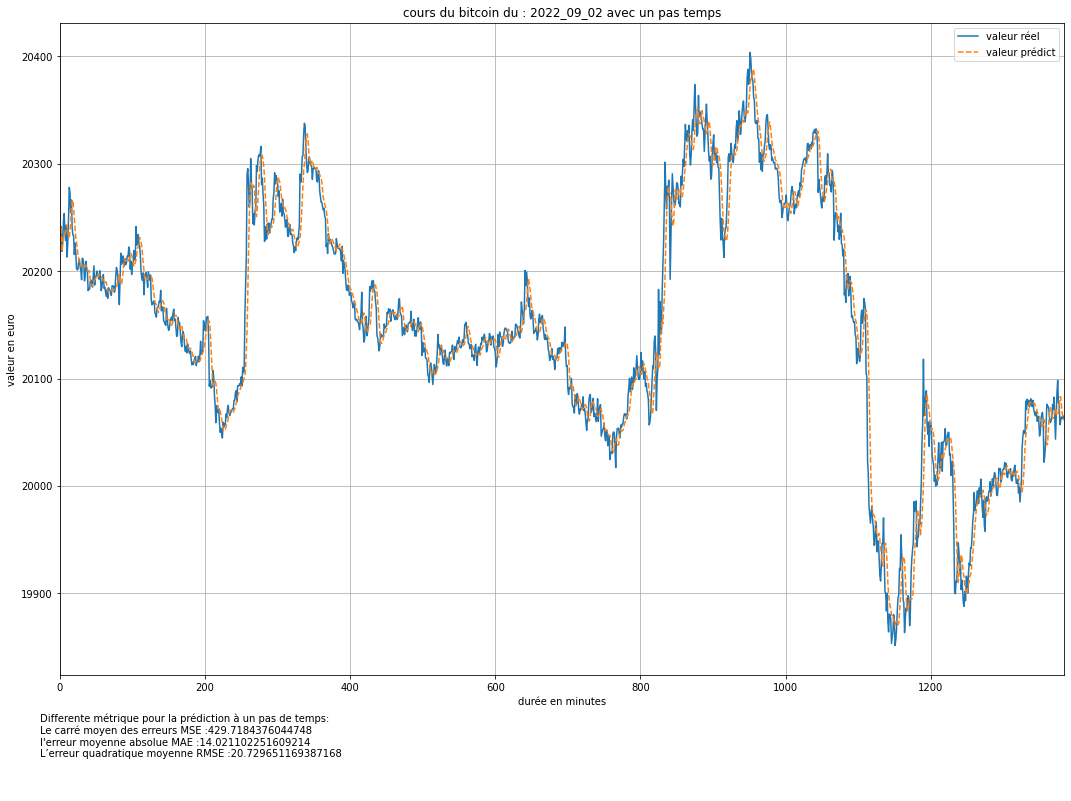

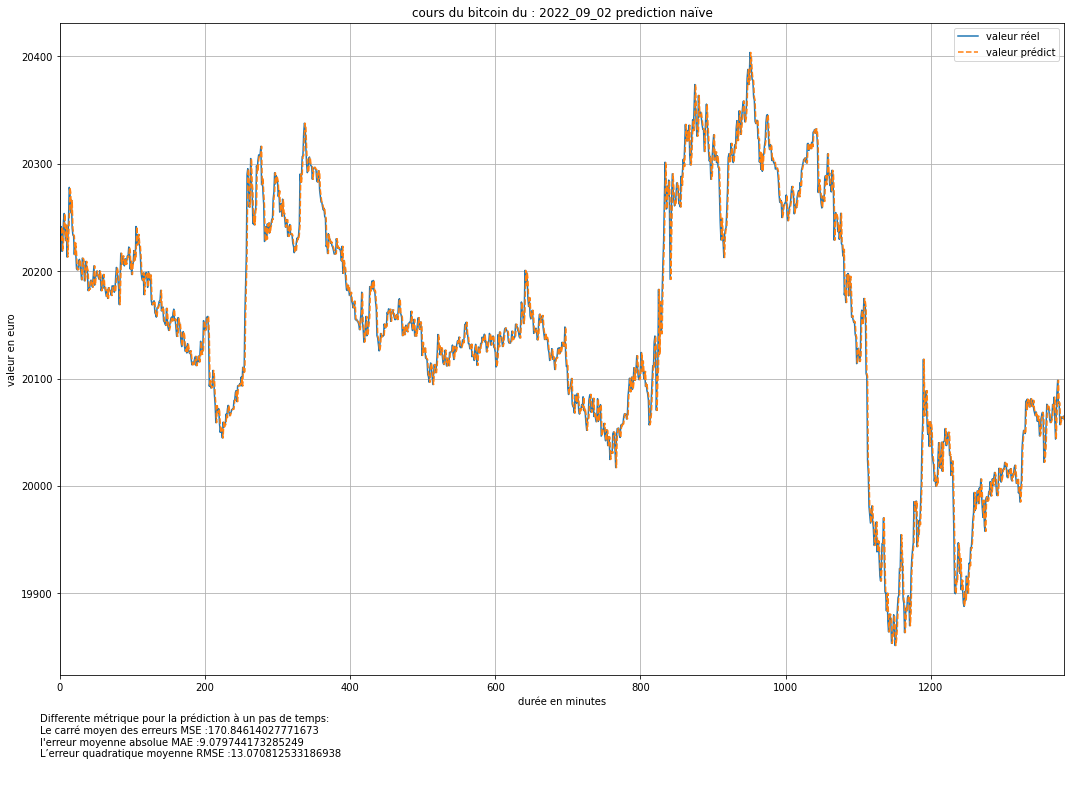

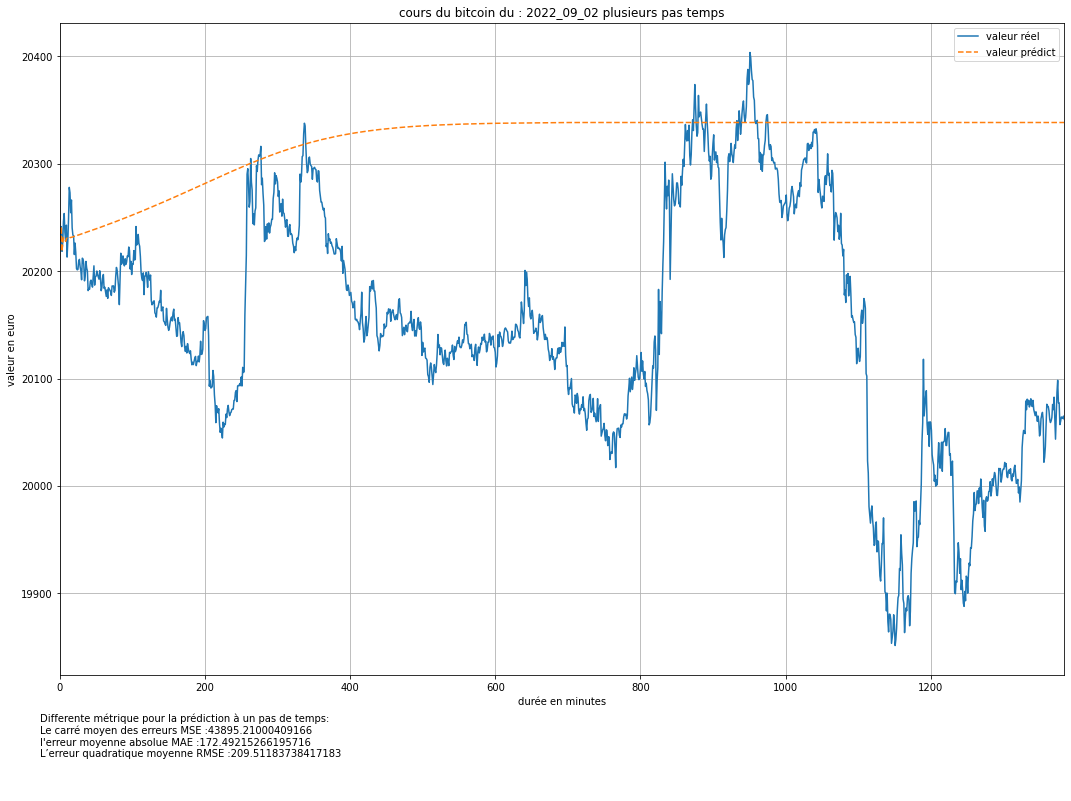

In [19]:
files = os.listdir("../data/test/")
for filename in files:
    print("\nTest file : "+filename)
    date_str = filename[10:-4]
    filename = "../data/test/"+filename
    
    #clear and prepross data
    newData = pd.read_csv(filename,sep=';')
    numberData=newData["cloture"].size
    print("nombre de donnée :",numberData)

    mean,std,newData = prepross_data(newData)
    
    #add prediction to data frame
    newData['valeur_predict_un_pas'] = prediction_un_pas_temps(newData['cloture'].to_numpy(),numberData)
    newData['valeur_predict_plusieurs_pas'] = prediction_plusieurs_pas_temps(newData['cloture'][:numFeature].to_numpy(),numberData)
    newData['valeur_predict_naif'] = prediction_naif(newData['cloture'].to_numpy(),numberData)
    
    #retransforme data and display it
    newData = retransforme(newData,std["cloture"],mean["cloture"])
    
    #calcul métrique prédiction à un pas de temps
    metric = calcul_metrics(newData['cloture'].to_numpy(),newData['valeur_predict_un_pas'].to_numpy(),numberData)
    affichage(newData['cloture'].to_numpy(),newData['valeur_predict_un_pas'].to_numpy(),date_str +" avec un pas temps",metric)
    
    #calcul métrique prédiction naïve
    metric = calcul_metrics(newData['cloture'].to_numpy(),newData['valeur_predict_naif'].to_numpy(),numberData)
    affichage(newData['cloture'].to_numpy(),newData['valeur_predict_naif'].to_numpy(),date_str +" prediction naïve",metric)
    
    #calcul prédiction sur une journée
    metric = calcul_metrics(newData['cloture'].to_numpy(),newData['valeur_predict_plusieurs_pas'].to_numpy(),numberData)
    affichage(newData['cloture'].to_numpy(),newData['valeur_predict_plusieurs_pas'].to_numpy(),date_str +" plusieurs pas temps",metric)
    
    
#     